**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm和岭回归为例), 并将模型加权组合成混合模型  

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 以沪深300数据集为例，构建特征和目标值，拟合特征与目标值，并评估模型
# 数据已经经过了初步清洗，剔除掉每天的涨跌停股和ST股，并使用后复权价格
# 如果不做回测，可以注释掉一切带"_test"的行

import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)

#sup_data = pd.read_csv('D:/Desktop/SH000300.csv')  # supplemental_data
#df = scutquant.join_data(df, sup_data, time='datetime', col=['idx_close'], index=['datetime', 'instrument'])  
df

open       close        high         low  \
datetime   instrument                                                   
2010-01-04 300003.SZ    51.590000   51.500000   51.850000   51.100000   
           300014.SZ    39.700000   39.470000   39.900000   39.240000   
           300015.SZ    48.970000   48.770000   49.190000   48.550000   
           300033.SZ    72.010000   74.570000   76.060000   71.610000   
           600000.SH    64.829142   62.928517   64.947931   62.839425   
...                           ...         ...         ...         ...   
2022-12-23 688363.SH   130.338644  130.842543  133.513211  129.078895   
           688396.SH    53.248294   52.735905   54.052042   52.344078   
           688561.SH    61.590000   67.160000   68.190000   61.590000   
           688599.SH    55.856185   54.938671   56.263968   53.909017   
           688981.SH    40.900000   41.060000   41.330000   40.830000   

                           volume        amount  
datetime   instrument                            
2010-01-04 300003.SZ     842437.0  4.328901e+07  
           300014.SZ     727706.0  2.873182e+07  
           300015.SZ     740314.0  3.613862e+07  
           300033.SZ    3627417.0  2.702477e+08  
           600000.SH   66191338.0  1.419984e+09  
...                           ...           ...  
2022-12-23 688363.SH    2334792.0  3.036193e+08  
           688396.SH    3462319.0  1.820840e+08  
           688561.SH    3554834.0  2.353862e+08  
           688599.SH   10072858.0  5.395502e+08  
           688981.SH    7428877.0  3.055459e+08  

[651282 rows x 6 columns]

In [3]:
# 清洗数据(由于原始数据已经经过了初步清洗，所以以下步骤可以省去)

# 查看缺失值和数据类型
df.info()
# 查看是否存在异常数据
#df.describe()
# 处理缺失值
#df.dropna(axis=1, how='all', inplace=True)  # 去除掉全为缺失值的列
#df = df.groupby(['instrument']).fillna(method='ffill').dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 651282 entries, ('2010-01-04', '300003.SZ') to ('2022-12-23', '688981.SH')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    651282 non-null  float64
 1   close   651282 non-null  float64
 2   high    651282 non-null  float64
 3   low     651282 non-null  float64
 4   volume  651282 non-null  float64
 5   amount  651282 non-null  float64
dtypes: float64(6)
memory usage: 32.4+ MB


**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 因子的构建方法有很多种, 关于因子可以查看alpha模块的注释以及量协的各种资料. 但我们在这里仅使用原始数据的0~59阶滞后项构建因子，让模型从它们张成的360维空间中寻找有用的信息预测目标值(可以跟tutorial(dnn)作比较)

In [4]:
# 下面开始构造目标值和特征

df['label'] = q.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'open': 'open',
    'close': 'close',
    'high': 'high',
    'low': 'low',
    'volume': 'volume',
    'amount': 'amount',
    'groupby': 'instrument'
}
features = alpha.alpha360(feature_kwargs, shift=60)  # 请使用自己的因子库以获得更好的表现
X = pd.concat([features, df['label']], axis=1)

# 伪市场因子,需要读取supplemental data
#df['idx_ret'] = scutquant.price2ret(df['idx_close'], shift1=1, shift2=0, groupby='instrument')
#X['market'] = df['idx_ret'] / df['close']
X.describe()

,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60,label
count,650972.000000,650662.000000,650352.000000,650042.000000,649732.000000,649422.000000,649112.000000,648802.000000,648492.000000,648182.000000,...,635162.000000,634852.000000,634542.000000,634232.000000,633922.000000,633612.000000,633302.000000,632992.000000,632682.000000,650662.000000
mean,0.999646,0.999795,0.999904,1.000015,1.000095,1.000132,1.000170,1.000211,1.000241,1.000267,...,0.670292,0.672526,0.674148,0.674286,0.674764,0.675455,0.675405,0.676280,0.678006,0.001135
std,0.044860,0.057142,0.066541,0.074905,0.082198,0.088265,0.093960,0.099543,0.104605,0.109342,...,1.225340,1.243914,1.268115,1.247027,1.247677,1.240679,1.224655,1.226982,1.232403,0.040568
min,0.166132,0.164244,0.160279,0.160846,0.156504,0.152917,0.160657,0.159797,0.160361,0.156032,...,0.000065,0.000089,0.000073,0.000093,0.000114,0.000058,0.000065,0.000089,0.000094,-0.800138
25%,0.980881,0.975806,0.971578,0.967645,0.964224,0.961395,0.958751,0.956028,0.953425,0.951082,...,0.103328,0.103330,0.102890,0.102933,0.102396,0.102185,0.102218,0.102042,0.101713,-0.012942
50%,1.000000,1.000000,1.000000,0.999706,0.999193,0.998865,0.998592,0.998437,0.998272,0.998062,...,0.306379,0.305397,0.305079,0.305049,0.304984,0.304329,0.304188,0.304335,0.303236,0.000000
75%,1.017802,1.022530,1.026616,1.030229,1.033143,1.035667,1.037846,1.040128,1.042442,1.044444,...,0.785283,0.786166,0.786983,0.786599,0.786404,0.786145,0.787050,0.786660,0.788496,0.012839
max,4.939980,4.836728,4.877892,4.977371,4.924201,4.939637,4.679046,5.279238,5.491916,5.248365,...,132.447588,123.966228,144.398790,140.269366,126.977188,115.125494,93.892558,99.391429,109.486339,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 361 entries, open1 to label
dtypes: float64(361)
memory usage: 1.6+ GB
None
X_mis= 1.6134781779619614
clean dataset done 

split data done 

label norm done 



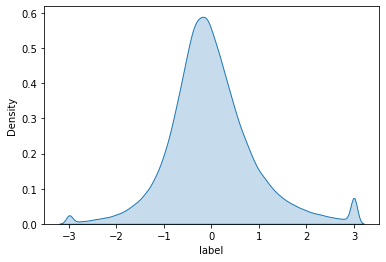

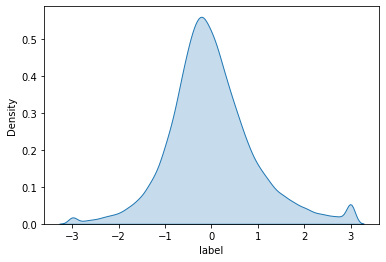

norm data done 

all works done 



,open1,open2,open3,open4,open5,open6,open7,open8,open9,open10,...,amount51,amount52,amount53,amount54,amount55,amount56,amount57,amount58,amount59,amount60
count,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,...,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000,449704.000000
mean,0.004462,0.004247,0.004138,0.003852,0.003419,0.003290,0.003044,0.002876,0.002620,0.002495,...,-0.031218,-0.031478,-0.031563,-0.031761,-0.031863,-0.032259,-0.032615,-0.033136,-0.033268,-0.033789
std,0.945240,0.944524,0.944937,0.946469,0.948267,0.947933,0.948996,0.950673,0.951058,0.951715,...,0.838306,0.837017,0.836812,0.835735,0.834759,0.832412,0.828413,0.825397,0.822946,0.818158
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-1.622040,-1.564835,-1.531300,-1.582167,-1.608953,-1.592867,-1.610310,-1.353262,-1.458082,-1.489419
25%,-0.501349,-0.504955,-0.508483,-0.513675,-0.520331,-0.524656,-0.527764,-0.534777,-0.538037,-0.540208,...,-0.582885,-0.582545,-0.582171,-0.580040,-0.578273,-0.575731,-0.572147,-0.570061,-0.566822,-0.562100
50%,0.059483,0.056403,0.055536,0.055196,0.053288,0.053118,0.054442,0.053129,0.052289,0.052451,...,-0.325805,-0.325126,-0.325268,-0.325000,-0.325221,-0.324090,-0.322520,-0.320478,-0.318952,-0.314967
75%,0.557077,0.558174,0.559404,0.562469,0.567256,0.570051,0.574811,0.578632,0.582338,0.585281,...,0.226385,0.221515,0.218809,0.218158,0.213622,0.208738,0.206412,0.203326,0.197676,0.191853
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [5]:
# 先拆分出测试集，然后做特征工程、数据清洗，最后可以根据mutual information score选择特征
X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]

# 使用auto_process()自动处理训练集和验证集(将在以后的版本完善拆分数据集的函数，使其能够同时处理训练、验证和测试集)
# select需要消耗大量时间，但可以过滤掉噪声。使用时需要在时间开销和模型性能之间权衡
result = q.auto_process(X, 'label', groupby='instrument', datetime='datetime', select=False, orth=False, label_norm=True)
x_train, y_train, x_valid, y_valid = result["X_train"], result["y_train"], result["X_test"], result["y_test"]
x_train.describe()

In [6]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = q.zscorenorm(x_test, x_test.groupby("datetime").mean(), x_test.groupby("datetime").std())

ymean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
ystd = y_test.groupby("instrument").shift(2).groupby("datetime").std()
ymean.fillna(0.0002, inplace=True)  # 假设年化5%, 即约为无风险收益率, 则每天应为0.0002
ystd.fillna(0.0189, inplace=True)  # 假设年化波动率为30%, 即0.3, 则每天的波动率应为0.0189

In [7]:
# 拟合模型
model = q.auto_lgbm(x_train, y_train, x_valid, y_valid)

pred = model.predict(x_test)
pred = pd.DataFrame(pred, columns=["predict"], index=x_test.index)
pred["predict"] += ymean
pred["predict"] *= ystd
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.837325	valid's l2: 0.890292
[40]	train's l2: 0.835405	valid's l2: 0.889752
[60]	train's l2: 0.833849	valid's l2: 0.889415
[80]	train's l2: 0.832535	valid's l2: 0.889266
[100]	train's l2: 0.831269	valid's l2: 0.889149
[120]	train's l2: 0.830065	valid's l2: 0.889092
[140]	train's l2: 0.82889	valid's l2: 0.889047
[160]	train's l2: 0.82769	valid's l2: 0.888947
[180]	train's l2: 0.826519	valid's l2: 0.888901
[200]	train's l2: 0.825374	valid's l2: 0.888863
[220]	train's l2: 0.824253	valid's l2: 0.88885
[240]	train's l2: 0.82318	valid's l2: 0.888799
[260]	train's l2: 0.822075	valid's l2: 0.888803
[280]	train's l2: 0.820982	valid's l2: 0.888796
Early stopping, best iteration is:
[255]	train's l2: 0.822336	valid's l2: 0.888783


,predict
count,70552.000000
mean,-0.000223
std,0.001405
min,-0.010013
25%,-0.001011
50%,-0.000255
75%,0.000546
max,0.008660


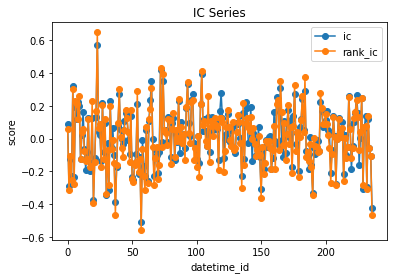

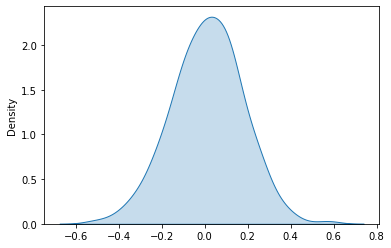

ic= 0.011263260660172298 icir= 0.06771477496571997 rank_ic= 0.00026131235903773995 rank_icir= 0.0014669876840730778


0.009841322999961965

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [9]:
# 以下为回测部分
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, time='datetime', price='close', volume='volume')

Accuracy of Prediction: 0.5466605932927177


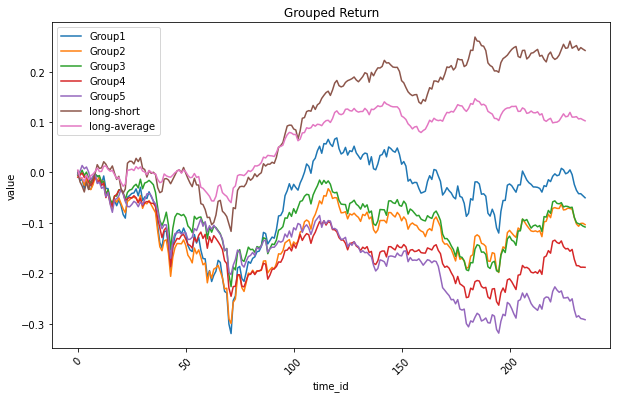

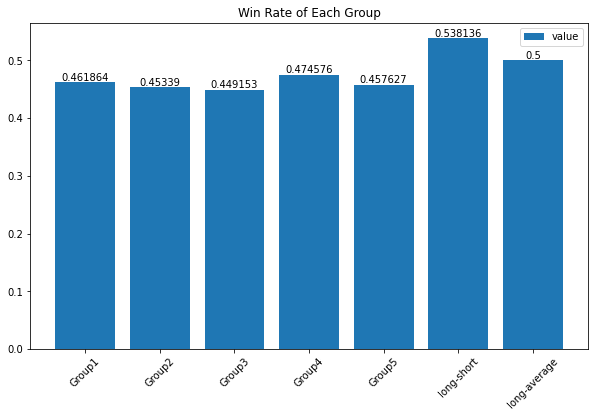

In [10]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

In [11]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": True,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": True,  # =True时，只做多不做空(在A股做空有一定的难度)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.01  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): -0.06766149074851344
std: 0.026882631299634006
E(r_benchmark): -0.12867191898052116
std_benchmark: 0.05329655828798661 

Cumulative Rate of Return: -0.10321209954240451
Cumulative Rate of Return(benchmark): -0.1858229210189083
Cumulative Excess Rate of Return: 0.08261082147650378 

Max Drawdown: -0.12952957276379085
Max Drawdown(benchmark): -0.23197087771901204 

Sharpe Ratio: -2.51997960222955
Sortino Ratio: 12.007181425988895
Information Ratio: 2.2695110293328447 

Pearson Correlation Coefficient Between Return and Benchmark: 0.962035943784424
Profitable Days(%): 0.9788135593220338


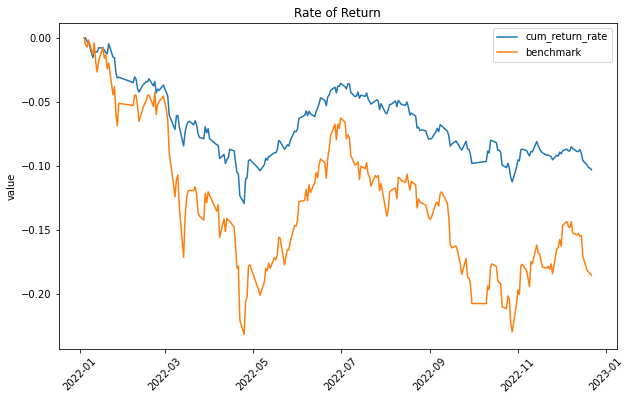

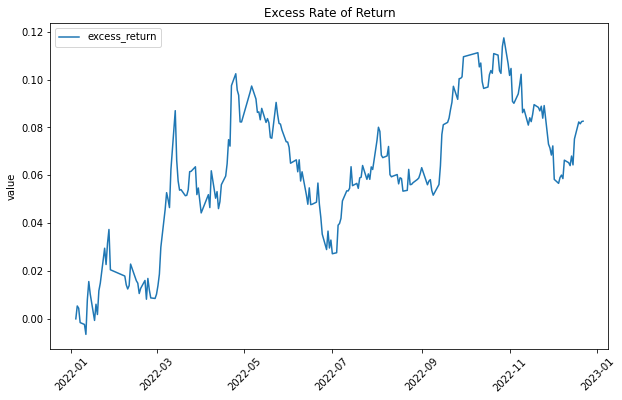

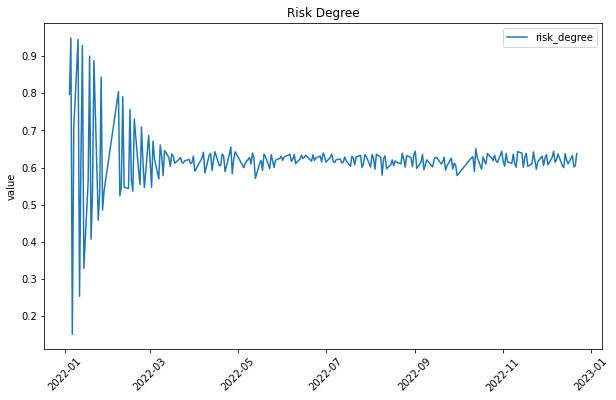

In [12]:
# 报告回测结果
# 对比2022年主动管理型基金的业绩，这表现算是在平均线以上
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
# user_account.buy_hist # 查看下单历史